# Data block API foundations

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_07a import *

Let's move beyond MNIST. ImageNet takes days to train on a single GPU. CIFAR10 contains 32x32 images, and it seems that small images have very different characteristics than larger ones. In particular, it seems that once you go beyond 96x96, things change quite a lot. So, stuff that works well on CIFAR10, does not really work on ImageNet. We would like to have a dataset that doesn't take days to train, but still is realistic enough.

Still Dmitro Mishkin found out that methods that worked well on 128x128 ImageNet images, still worked well on the full size images. The full ImageNet at 128x128 is still too big. J.H. created a dataset called *imaginette* that is a subset of ImageNet containing 10 out of the 1000 classes. There are multiple versions: full size, 320px, 160px. The classes are very different to each other, and this dataset is supposed to be easy. You should be able to train for just an epoch or two and have an idea of the performance.

The *Imagewoof* is, conversely, a dataset of dog breeds, and it's supposed to be hard. It is available in the same formats.

There is a leaderboard for either dataset. J.H. says that working on these two datasets has given him more insights on CV than (as usual) anything else he's ever done. He says that putting your own version of a toy problem can be very helpful having a better understanding of the domain you are working on.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=600)

In [3]:
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160'

## Image ItemList

Previously we were reading in to RAM the whole MNIST dataset at once, loading it as a pickle file. We can't do that for datasets larger than our RAM capacity, so instead we leave the images on disk and just grab the ones we need for each mini-batch as we use them. In so doing we will build a `DataBlock` API. By the end of this notebook you should be able to build your own `DataBlock` API or modify fastai's.

Let's use the [imagenette dataset](https://github.com/fastai/imagenette/blob/master/README.md) and build the data blocks we need along the way.

### Get images

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/home/giovenko/.fastai/data/imagenette2-160')

In general, if we want to read files of a given format we need to rely on a library that supports such format. In the case of images we rely on the Python Image Library (PIL).
To be able to look at what's inside a directory from a notebook, we add the `.ls` method to `Path` with a monkey-patch.

In [5]:
# export
import PIL
import os
import mimetypes
Path.ls = lambda x: list(x.iterdir())

In [6]:
path.ls()

[PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train')]

The command below will show the 10 categories (the names are not terribly informative).

In [7]:
(path/'val').ls()

[PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03417042'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03445777'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03028079'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03000684'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03425413'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n01440764'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n02102040'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03888257'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n02979186'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03394916')]

Let's have a look inside a class folder (the first class is tench):
Interesting observation from J.H.: "they are pretty much always held up by middle aged men, or in nets".

In [8]:
path_tench = path/'val'/'n01440764'

In [9]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n01440764/n01440764_7501.JPEG')

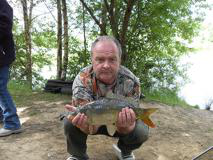

In [10]:
img = PIL.Image.open(img_fn)
img

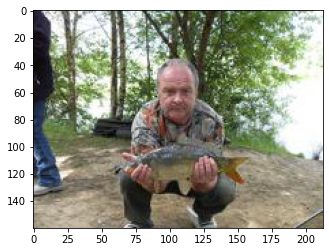

In [11]:
plt.imshow(img)

In [12]:
import numpy
imga = numpy.array(img)

In [13]:
imga.shape

(160, 213, 3)

In [14]:
imga[:10, :10, 0]

array([[ 44,  39,  41,  51, ..., 156, 255, 255, 252],
       [ 36,  35,  37,  43, ..., 109, 187, 213, 194],
       [ 33,  38,  40,  43, ...,  67, 114, 232, 179],
       [ 31,  39,  42,  43, ...,  52,  73, 167, 224],
       ...,
       [ 29,  33,  31,  37, ...,  39,  49,  75,  35],
       [ 27,  30,  32,  41, ...,  35,  47,  42,  59],
       [ 28,  34,  40,  42, ...,  45,  49,  44,  56],
       [ 30,  35,  40,  41, ...,  44,  48,  45,  65]], dtype=uint8)

Just in case there are other files in the directory (models, texts...) we want to keep only the images. Let's not write it out by hand, but instead use what's already on our computer (the MIME types database).

In [15]:
#export
image_extensions = set(
    k for k, v in mimetypes.types_map.items() if v.startswith('image/'))

In [16]:
' '.join(image_extensions)

'.xbm .tif .gif .xpm .jpe .bmp .jpeg .ief .ico .jpg .ras .svg .pbm .xwd .pnm .ppm .rgb .tiff .png .pgm'

In [17]:
#export
def setify(o):
    return o if isinstance(o, set) else set(listify(o))

In [18]:
test_eq(setify('aa'), {'aa'})
test_eq(setify(['aa', 1]), {'aa', 1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

Now let's walk through the directories and grab all the images. The first private function grabs all the images inside a given directory and the second one walks (potentially recursively) through all the folder in `path`.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=1325)

In [19]:
# export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

`os.scandir()` takes a path and returns the content of that path. You can learn more [here](https://docs.python.org/3/library/os.html#os.scandir). `os.scandir()` is very fast, as it's a thin wrapper around a C function.

In [20]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/home/giovenko/.fastai/data/imagenette2-160/n01440764_7501.JPEG'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/n01440764_12090.JPEG'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/n01440764_21052.JPEG')]

`os.walk()` generates the files in a directory tree by walking the tree either top-down or bottom-up. You can learn more [here](https://docs.python.org/3/library/os.html#os.walk). `os.walk()` internally relies on `os.scandir()`.

In [21]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i, (p, d, f) in enumerate(os.walk(path)):  # returns (dirpath, dirnames, filenames)
            if include is not None and i == 0:
                d[:] = [o for o in d if o in include]
            else:
                d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [22]:
get_files(path_tench, image_extensions)[:3]

[PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n01440764/n01440764_7501.JPEG'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n01440764/n01440764_12090.JPEG'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n01440764/n01440764_21052.JPEG')]

We need the recurse argument when we start from `path` since the pictures are two level below in directories.

In [23]:
get_files(path, image_extensions, recurse=True)[:3]

[PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03417042/n03417042_27231.JPEG'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03417042/n03417042_1611.JPEG'),
 PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03417042/n03417042_2231.JPEG')]

In [24]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

Imagenet is 100 times bigger than imagenette, so we need this to be fast.

In [25]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

52.2 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Prepare for modeling

This is the list of things that, eventually, form a `DataBlock`.

What we need to do:

- Get files
- Split validation set
  - random%, folder name, csv, ...
- Label: 
  - folder name, file name/re, csv, ...
- Transform per image (optional)
- Transform to tensor
- DataLoader
- Transform per batch (optional)
- DataBunch
- Add test set (optional)

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=1728)

### Get files

We use the `ListContainer` class from notebook 06 to store our objects in an `ItemList`. The `get` method will need to be subclassed to explain how to access an element (open an image for instance), then the private `_get` method can allow us to apply any additional transform to it.

`compose` is based on functional programming concepts and what it does is to take an object `x` and a list of functions and  and in turn transform `x` by applying the functions in the list and assign the result to `x` itself. By doing this, we are composing multiple transformations.

```python
def compose(x, funcs, *args, order_key='_order', **kwargs):
    def key(o):
        return getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key):
        x = f(x, **kwargs)
    return x
```

`compose` has in addition an optional ordering key and some keyword arguments. Python contains a number of functions to implement functional programming concepts. You can learn more [here](https://docs.python.org/3.8/library/functools.html).

In our case, `compose` is used in `get(self, i)` and applies the transformation functions in `tfms` to the item `i`.

`new` will be used in conjunction with `__getitem__` (that works for one index or a list of indices) to create training and validation set from a single stream when we split the data.

`ImageList` takes a list of files and passes them to the class constructor `cls` which expects a list of items `items`.

In [26]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    def key(o):
        return getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key):
        x = f(x, **kwargs)
    return x


class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path = Path(path)
        self.tfms = tfms

    def __repr__(self):
        return f'{super().__repr__()}\nPath: {self.path}'

    def new(self, items, cls=None):
        if cls is None:
            cls = self.__class__
        return cls(items, self.path, tfms=self.tfms)

    def get(self, i):
        return i

    def _get(self, i):
        return compose(self.get(i), self.tfms)

    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res, list):
            return [self._get(o) for o in res]
        return self._get(res)


class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None:
            extensions = image_extensions
        return cls(
            get_files(path, extensions, recurse=recurse, include=include),
            path, **kwargs)

    def get(self, fn): return PIL.Image.open(fn)

One frequent problem is that sometimes there are black and white images mixed with the RGB ones. When PIL reads a black and white image, it returns a rank 2 tensor (just x and y, no channels), and we cannot stack it into a mini-batch. This is why we are adding the `MakeRGB` class below. We could, instead, just use a function, like `make_rgb()` below. Both approaches are fine.

Transforms aren't only used for data augmentation. To allow total flexibility, `ImageList` returns the raw PIL image. The first thing is to convert it to 'RGB' (or something else).

Transforms only need to be functions that take an element of the `ItemList` and transform it. If they need state, they can be defined as a class. Also, having them as a class allows to define an `_order` attribute (default 0) that is used to sort the transforms.

In [27]:
#export
class Transform():
    _order = 0


class MakeRGB(Transform):
    def __call__(self, item):
        return item.convert('RGB')


def make_rgb(item):
    return item.convert('RGB')

In [28]:
il = ImageList.from_files(path, tfms=make_rgb)

In [29]:
il

ImageList (13394 items)
[PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03417042/n03417042_27231.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03417042/n03417042_1611.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03417042/n03417042_2231.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03417042/n03417042_10401.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03417042/n03417042_4761.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03417042/n03417042_10642.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03417042/n03417042_24020.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03417042/n03417042_10752.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03417042/n03417042_26850.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03417042/n03417042_1840.JPEG')...]
Path: /home/giovenko/.fastai/data/imagenette2-

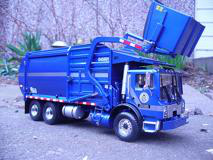

In [30]:
img = il[0]; img

We can also index with a range or a list of integers:

In [31]:
il[:1]

[<PIL.Image.Image image mode=RGB size=213x160 at 0x7F9F743E7C50>]

### Split validation set

Here, we need to split the files between those in the folder train and those in the folder val.

In [32]:
fn = il.items[0]
fn

PosixPath('/home/giovenko/.fastai/data/imagenette2-160/val/n03417042/n03417042_27231.JPEG')

Since our filenames are `path` object, we can find the directory of the file with `.parent`. We need to go back two folders before since the last folders are the class names.

In [33]:
fn.parent.parent.name

'val'

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=2175)

The function `grandparent_splitter()` returns a boolean value that equals `True` if we are working with the validation set, `False` if it's the training set, and `None` otherwise.

In [34]:
#export
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp == valid_name else False if gp == train_name else None


def split_by_func(items, f):
    mask = [f(o) for o in items]
    # `None` values will be filtered out
    f = [o for o, m in zip(items, mask) if m == False]
    t = [o for o, m in zip(items, mask) if m == True]
    return f, t

In [35]:
splitter = partial(grandparent_splitter, valid_name='val')

In [36]:
%time train,valid = split_by_func(il, splitter)

CPU times: user 25.3 ms, sys: 87 µs, total: 25.3 ms
Wall time: 25.3 ms


In [37]:
len(train), len(valid)

(9469, 3925)

Now that we can split our data, let's create the class that will contain it. It just needs two `ItemList` to be initialized, and we create a shortcut to all the unknown attributes by trying to grab them in the `train` `ItemList`.

The `__getattr__()` method makes it so that if we look for an attributes it doesn't know about it will grab it from the training set.

`il.new` uses the `new()` method in the `ItemList`, shown below.

```python
def new(self, items, cls=None):
    if cls is None:
        cls = self.__class__
    return cls(items, self.path, tfms=self.tfms)
```

`new()` is going to create a new `ItemList` with the same path, transforms etc, but with those `items`.

In [38]:
#export
class SplitData():
    def __init__(self, train, valid):
        self.train = train
        self.valid = valid

    def __getattr__(self, k):
        return getattr(self.train, k)
    # This is needed if we want to pickle SplitData and be able to load it back without recursion errors

    def __setstate__(self, data: Any):
        self.__dict__.update(data)

    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f))
        return cls(*lists)

    def __repr__(self):
        return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [39]:
sd = SplitData.split_by_func(il, splitter)
sd

SplitData
Train: ImageList (9469 items)
[PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_29384.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_7225.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/ILSVRC2012_val_00044888.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_26713.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_7204.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_29836.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_23067.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_7369.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_27383.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_924.JPEG')...]
Pat

### Labeling

Labeling has to be done *after* splitting, because it uses *training* set information to apply to the *validation* set, using a *Processor*.

A *Processor* is a transformation that is applied to all the inputs once at initialization, with some *state* computed on the training set that is then applied without modification on the validation set (and maybe the test set or at inference time on a single item). For instance, it could be **processing texts** to **tokenize**, then **numericalize** them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.

Another example is in **tabular data**, where we **fill missing values** with (for instance) the median computed on the training set. That statistic is stored in the inner state of the *Processor* and applied on the validation set.

In our case, we want to **convert label strings to numbers** in a consistent and reproducible way. So we create a list of possible labels in the training set, and then convert our labels to numbers based on this *vocab*.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=2368)

In [40]:
#export
from collections import OrderedDict


def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort:
        res.sort()
    return res

First, let's define the processor. We also define a `ProcessedItemList` with an `obj` method that can get the unprocessed items: for instance a processed label will be an index between 0 and the number of classes - 1, the corresponding `obj` will be the name of the class. The first one is needed by the model for the training, but the second one is better for displaying the objects.

In [41]:
# export
class Processor():
    def process(self, items):
        return items


class CategoryProcessor(Processor):
    def __init__(self):
        self.vocab = None

    def __call__(self, items):
        # The vocab is defined on the first use.
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi = {v: k for k, v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]

    def proc1(self, item):
        return self.otoi[item]

    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]

    def deproc1(self, idx):
        return self.vocab[idx]

Here we label according to the folders of the images, so simply `fn.parent.name`. We label the training set first with a newly created `CategoryProcessor` so that it computes its inner `vocab` on that set. Then we label the validation set using the same processor, which means it uses the same `vocab`. The end result is another `SplitData` object.

In [42]:
#export
def parent_labeler(fn):
    return fn.parent.name


def _label_by_func(ds, f, cls=ItemList):
    return cls([f(o) for o in ds.items], path=ds.path)

# This is a slightly different from what was seen during the lesson,
#   we'll discuss the changes in lesson 11


class LabeledData():
    def process(self, il, proc):
        return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x = self.process(x, proc_x)
        self.y = self.process(y, proc_y)
        self.proc_x = proc_x
        self.proc_y = proc_y

    def __repr__(self):
        return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

    def x_obj(self, idx):
        return self.obj(self.x, idx, self.proc_x)

    def y_obj(self, idx):
        return self.obj(self.y, idx, self.proc_y)

    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(
            idx, torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item

    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)


def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(
        sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(
        sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train, valid)

In [43]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [44]:
assert ll.train.proc_y is ll.valid.proc_y

In [45]:
ll.train.y

ItemList (9469 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: /home/giovenko/.fastai/data/imagenette2-160

In [46]:
ll.train.y.items[0], ll.train.y_obj(0), ll.train.y_obj(slice(2))

(0, 'n03417042', ['n03417042', 'n03417042'])

In [47]:
ll

SplitData
Train: LabeledData
x: ImageList (9469 items)
[PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_29384.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_7225.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/ILSVRC2012_val_00044888.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_26713.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_7204.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_29836.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_23067.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_7369.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_27383.JPEG'), PosixPath('/home/giovenko/.fastai/data/imagenette2-160/train/n03417042/n03417042_924

### Transform to tensor

We still cannot train a model because we have PIL objects, not tensors.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=3044)

In [48]:
ll.train[0]

(<PIL.Image.Image image mode=RGB size=213x160 at 0x7F9F6FA36128>, 0)

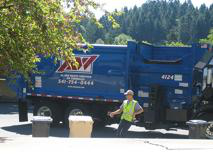

In [49]:
ll.train[0][0]

To be able to put all our images in a batch, we need them to have all the same size. We can do this easily in PIL. Apparently it's not a great way to do it, but it's a start.

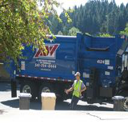

In [50]:
ll.train[0][0].resize((128,128))

A better way is to use a transform. It has to be after all the other transforms we have seen so far.
The first transform resizes to a given size, then we convert the image to a byte tensor before converting it to float and dividing by 255. This has to happen after resizing, and the conversion to float tensors must happen after the conversion to byte tensors. Note that we can just add state to objects with simple assignments, as is the case of `to_byte_tensor.order = 20`.
We will investigate data augmentation transforms at length in notebook 10.

Pillow puts the channel last, while PyTorch assumes that the channel comes first. This is why we have a `.permute(2, 0, 1)`.

In [51]:
#export
class ResizeFixed(Transform):
    _order = 10

    def __init__(self, size):
        if isinstance(size, int):
            size = (size, size)
        self.size = size

    def __call__(self, item):
        return item.resize(self.size, PIL.Image.BILINEAR)


def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w, h = item.size
    return res.view(h, w, -1).permute(2, 0, 1)


to_byte_tensor._order = 20


def to_float_tensor(item):
    return item.float().div_(255.)


to_float_tensor._order = 30

In [52]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

Here is a little convenience function to show an image from the corresponding tensor.

In [53]:
#export
def show_image(im, figsize=(3, 3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1, 2, 0))

In [54]:
x, y = ll.train[0]
x.shape

torch.Size([3, 128, 128])

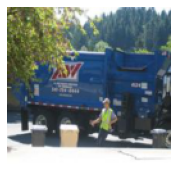

In [55]:
show_image(x)

## Modeling

### DataBunch

Now we are ready to put our datasets together in a `DataBunch`.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=3226)

In [56]:
bs = 64

In [57]:
train_dl, valid_dl = get_dls(ll.train, ll.valid, bs, num_workers=4)

In [58]:
x, y = next(iter(train_dl))

In [59]:
x.shape

torch.Size([64, 3, 128, 128])

We can still see the images in a batch and get the corresponding classes.

'n03000684'

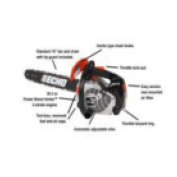

In [60]:
show_image(x[0])
ll.train.proc_y.vocab[y[0]]

In [61]:
y

tensor([3, 1, 7, 9, 7, 4, 0, 6, 5, 8, 0, 6, 5, 4, 9, 4, 4, 5, 3, 9, 2, 5, 7, 5,
        4, 1, 8, 4, 5, 7, 6, 0, 3, 3, 6, 0, 0, 0, 2, 0, 0, 0, 5, 8, 0, 5, 6, 4,
        2, 7, 7, 6, 6, 3, 7, 0, 2, 1, 1, 2, 5, 9, 2, 7])

We change a little bit our `DataBunch` to add a few attributes: `c_in` (for channel in) and `c_out` (for channel out) instead of just `c`. This will help when we need to build our model.

In [62]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.c_in = c_in
        self.c_out = c_out

    @property
    def train_ds(self):
        return self.train_dl.dataset

    @property
    def valid_ds(self):
        return self.valid_dl.dataset

Then we define a function that goes directly from the `SplitData` to a `DataBunch`. **Question** shall we include this directly into the `SplitData` class. This is a "monkey patch", according to J.H.

In [63]:
#export
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)


SplitData.to_databunch = databunchify

This gives us the full summary on how to grab our data and put it in a `DataBunch`:

In [64]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(
    grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

### Model

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=3360)

In [65]:
cbfs = [partial(AvgStatsCallback, accuracy),
        CudaCallback]

We will normalize with the statistics from a batch.

In [66]:
m, s = x.mean((0, 2, 3)).cuda(), x.std((0, 2, 3)).cuda()
m, s

(tensor([0.4679, 0.4523, 0.4277], device='cuda:0'),
 tensor([0.2758, 0.2774, 0.2927], device='cuda:0'))

In [67]:
#export
def normalize_chan(x, mean, std):
    return (x-mean[..., None, None]) / std[..., None, None]


_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])

norm_imagenette = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

In [68]:
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))

In [69]:
nfs = [64, 64, 128, 256]

We build our model using [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187), in particular: we don't use a big conv 7x7 at first but three 3x3 convs, and don't go directly from 3 channels to 64 but progressively add those.

`l1 = data.c_in` reads the number of input channels automatically. If we change the type of images from 3 to 1 (or 4 or whatever) channels, we don't have to change anything.

If the input has `c_in` channels and a kernel of size 3, then we have 9*`c_in` numbers coming in, and we want to have *fewer* numbers going out. The function `prev_pow_2` takes a number `x` and looks for the closest power of two that is smaller or equal to it. Then, for the next two layers, we multiply by 2. In the `Bag of Tricks` paper there is an analysis of why 3x3 gives "more bang for your buck".

In [70]:
#export
import math


def prev_pow_2(x):
    return 2**math.floor(math.log2(x))


def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2):
        return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = prev_pow_2(l1 * 3 * 3)
    layers = [f(l1, l2, stride=1),
              f(l2, l2 * 2, stride=2),
              f(l2 * 2, l2 * 4, stride=2)]
    nfs = [l2 * 4] + nfs
    layers += [f(nfs[i], nfs[i + 1]) for i in range(len(nfs) - 1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten),
               nn.Linear(nfs[-1], data.c_out)]
    return layers


def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))


def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [71]:
sched = combine_scheds([0.3, 0.7], cos_1cycle_anneal(0.1, 0.3, 0.05))

In [72]:
learn, run = get_learn_run(nfs, data, 0.2, conv_layer, cbs=cbfs+[
    partial(ParamScheduler, 'lr', sched)
])

And we can train the model:

In [73]:
%time run.fit(5, learn)

train: [1.8421407190569226, tensor(0.3609, device='cuda:0')]
valid: [1.8496091261942675, tensor(0.3720, device='cuda:0')]
train: [1.4508011133369416, tensor(0.5080, device='cuda:0')]
valid: [1.3750859623805733, tensor(0.5378, device='cuda:0')]
train: [1.1203617148722147, tensor(0.6290, device='cuda:0')]
valid: [1.1368223775875796, tensor(0.6339, device='cuda:0')]
train: [0.8161552252745802, tensor(0.7385, device='cuda:0')]
valid: [1.1020506568471338, tensor(0.6456, device='cuda:0')]
train: [0.5774220482627521, tensor(0.8232, device='cuda:0')]
valid: [1.0415840216958598, tensor(0.6637, device='cuda:0')]
CPU times: user 10.5 s, sys: 3.97 s, total: 14.5 s
Wall time: 21.7 s


Let's have a look at our model using Hooks. We print the layers and the shapes of their outputs.

In [74]:
#export
def model_summary(run, learn, data, find_all=False):
    xb, yb = get_batch(data.valid_dl, run)
    # Model may not be on the GPU yet
    device = next(learn.model.parameters()).device
    xb, yb = xb.to(device), yb.to(device)
    mods = find_modules(
        learn.model, is_lin_layer) if find_all else learn.model.children()

    def f(hook, mod, inp, out):
        return print(f"{mod}\n{out.shape}\n")
    with Hooks(mods, f) as hooks:
        learn.model(xb)

In [75]:
# This must be called after training the model, not before as in the video.
# If you do as in the original notebook you get the following
# AttributeError: 'Runner' object has no attribute 'in_train'
model_summary(run, learn, data)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 16, 128, 128])

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 32, 64, 64])

Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 32, 32])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 16, 16])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(

The [leaderboard](https://github.com/fastai/imagenette/blob/master/README.md) as this notebook is written has ~85% accuracy for 5 epochs at 128px size, so we're definitely on the right track!

## Export

In [76]:
!python notebook2script.py 08_data_block.ipynb

Converted 08_data_block.ipynb to exp/nb_08.py
